# MDD fMRI analysis with UKF - coupled oscillator model

## Libraries

In [1]:
library(KernSmooth)
library(deSolve)
library(ggplot2)
#library(devtools)
#install_github("insilico/UKF")  
#library(UKF)
#install.packages(c('KernSmooth'))
library(data.table)
library(dplyr)
library(tidyr)
library(Matrix)
# hide warnings
options(warn=-1)

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Warning message:
"package 'deSolve' was built under R version 4.3.3"
Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Warning message:
"package 'data.table' was built under R version 4.3.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack




In [2]:
options(repr.plot.width=10, repr.plot.height=6)

## Functions

In [3]:
###################################
# UKF.R Engine of library
# Unscented Kalman Filter Functions
###################################

#=====================================================#
#' UKF_dT
#' Unscented Kalman Filter (UKF) for time step dT (Streamlined Version)
#' Doesn't use data at this step;
#' UKF_blend fn later blends UKF with data after dT step.
#' This function was known previously as
#' multiple_param_unscented_kalman_filter.
#' This function is a streamlined version of standard UKF.
#' It is designed to be more efficient and easier to use.
#' This is the default UKF method used in the package.
#' @param t_dummy a dummy time variable, because ode models don't have explcit time
#' @param ode_model model with variables y and N_p parameters
#' @param xhat UFK posterior prediction of augmented states (param + ind vars)
#' @param Pxx augmented covariance matrix for sigma points
#' @param y independent variable state vector
#' @param N_p number of unknown model params
#' @param N_y number of ind variables
#' @param R covariance matrix of y state. initialized in UKF_blend and updated with sigma points as Pyy in current function.
#' @param dt smaller time step size within dT
#' @param dT time step size that comes from time series data step
#' @param R_scale related to standard deviation of Gaussian measurement noise of ind variables. A number that must be specified by user.
#' @param Q_scale related to standard deviation of process noise. Noise related to model parameters
#' @param forcePositive logical, if TRUE, ensures all parameters stay positive
#' @return list: xhat (augmented Kalman update), Pxx (augmented covariance at sigma points), and K (Kalman gain matrix)
#' @examples
#' Example
#' @export
UKF_dT <- function(t_dummy, ode_model, xhat, Pxx, y, N_p, N_y, R, dt, dT,
                    R_scale, Q_scale, forcePositive = FALSE) {
  N_x <- N_p + N_y # number of augmented states
  N_sigma <- 2 * N_x # number sigma points
  
  # Add jitter to Pxx for numerical stability before Cholesky
  jitter_Pxx <- 0
  max_jitter_Pxx <- 1e-2
  success_Pxx <- FALSE
  first_step_Pxx <- TRUE
  
  while (!success_Pxx && jitter_Pxx <= max_jitter_Pxx) {
    Pxx_jittered <- Pxx + diag(jitter_Pxx, N_x)
    xsigma <- tryCatch(t(chol(N_x * Pxx_jittered, pivot = T)),
                      error = function(e) NULL)
    if (!is.null(xsigma)) {
      success_Pxx <- TRUE
    } else {
      if (first_step_Pxx) {
        jitter_Pxx <- 1e-8
        first_step_Pxx <- FALSE
      } else {
        jitter_Pxx <- jitter_Pxx * 10
      }
    }
  }
  
  # If still failing, use nearPD
  if (!success_Pxx) {
    if (!requireNamespace("Matrix", quietly = TRUE)) {
      stop("Cholesky decomposition failed and package 'Matrix' is not available for nearPD.")
    }
    Pxx_pd <- as.matrix(Matrix::nearPD(N_x * Pxx)$mat)
    xsigma <- t(chol(Pxx_pd, pivot = T))
  }
  
  # Unscented Sigma Points
  Xa <- xhat %*%
    matrix(rep(1, length = N_sigma), nrow = 1, ncol = N_sigma) +
    cbind(xsigma, -xsigma)

  X <- propagate_model(t_dummy, ode_model, dt, dT, N_p, Xa, method = "streamlined")
  xtilde <- t(t(rowSums(X)) / N_sigma)

  Pxx <- matrix(rep(0, length = N_x * N_x), nrow = N_x, ncol = N_x)
  for(i in 1:N_sigma){
    Pxx <- Pxx + ((X[, i] - xtilde) %*% t(X[, i] - xtilde)) / N_sigma
  }

  # Add process noise Q at each step (only to parameter block)
  Q <- matrix(0, nrow = N_x, ncol = N_x)
  Q[1:N_p, 1:N_p] <- Q_scale * diag(N_p)
  Pxx <- Pxx + Q  # Add process noise to covariance

  # grab first N_y ind vars
  # skip N_p params from augmented
  # previously used multiple_param_obs_fct
  Y <- X[(N_p + 1):(N_p + N_y),]
  ytilde <- t(t(rowSums(Y)) / N_sigma)

  Pyy <- R
  for(i in 1:N_sigma){
    Pyy <- Pyy + ((Y[, i] - ytilde) %*% t(Y[, i] - ytilde)) / N_sigma
  }

  # Add numerical stability to Pyy matrix
  jitter_Pyy <- 0
  max_jitter_Pyy <- 1e-2
  success_Pyy <- FALSE
  first_step_Pyy <- TRUE
  
  while (!success_Pyy && jitter_Pyy <= max_jitter_Pyy) {
    Pyy_jittered <- Pyy + diag(jitter_Pyy, N_y)
    # Check condition number
    eigvals <- eigen(Pyy_jittered, symmetric = TRUE, only.values = TRUE)$values
    cond_num <- max(eigvals) / min(eigvals)
    
    if (all(eigvals > 1e-12) && cond_num < 1e12) {
      Pyy <- Pyy_jittered
      success_Pyy <- TRUE
    } else {
      if (first_step_Pyy) {
        jitter_Pyy <- 1e-8
        first_step_Pyy <- FALSE
      } else {
        jitter_Pyy <- jitter_Pyy * 10
      }
    }
  }
  
  # If still not stable, force using nearPD
  if (!success_Pyy) {
    if (!requireNamespace("Matrix", quietly = TRUE)) {
      stop("Pyy matrix is singular and package 'Matrix' is not available for nearPD.")
    }
    Pyy <- as.matrix(Matrix::nearPD(Pyy)$mat)
  }

  Pxy <- matrix(rep(0, length = N_x * N_y), nrow = N_x, ncol = N_y)
  for(i in 1:N_sigma){
    Pxy <- Pxy + ((X[, i] - xtilde) %*% t(Y[, i] - ytilde)) / N_sigma
  }
  
  # Use pseudoinverse for additional numerical stability
  K <- tryCatch({
    Pxy %*% solve(Pyy)
  }, error = function(e) {
    # Fallback to pseudoinverse
    if (!requireNamespace("MASS", quietly = TRUE)) {
      stop("Matrix inversion failed and package 'MASS' is not available for pseudoinverse.")
    }
    Pxy %*% MASS::ginv(Pyy)
  })

  xhat <- xtilde + K %*% (y - ytilde)
  
  if (forcePositive) {
    param_min <- 1e-8  # Smallest allowed value for parameters
    xhat[1:N_p] <- pmax(param_min, xhat[1:N_p])  # Ensure positive
  }
  
  Pxx <- Pxx - K %*% t(Pxy)
  
  # Ensure Pxx remains positive definite
  eigvals_Pxx <- eigen(Pxx, symmetric = TRUE, only.values = TRUE)$values
  if (any(eigvals_Pxx <= 0)) {
    if (!requireNamespace("Matrix", quietly = TRUE)) {
      # Simple fix: add small diagonal term
      Pxx <- Pxx + diag(1e-6, N_x)
    } else {
      Pxx <- as.matrix(Matrix::nearPD(Pxx)$mat)
    }
  }

  # xhat is Kalman augmented prediction
  return(list(xhat = xhat, Pxx = Pxx, K = K))
} # ENDFN UKF

#=====================================================#
#' UKF_dT_std
#' Unscented Kalman Filter (UKF) for time step dT (Standard Version)
#' Doesn't use data at this step;
#' UKF_blend fn later blends UKF with data after dT step.
#' To use this function, you must specify the method as "standard" in UKF_blend.
#' @param t_dummy a dummy time variable, because ode models don't have explcit time
#' @param ode_model model with variables y and N_p parameters
#' @param xhat UFK posterior prediction of augmented states (param + ind vars)
#' @param Pxx augmented covariance matrix for sigma points
#' @param y independent variable state vector
#' @param N_p number of unknown model params
#' @param N_y number of ind variables
#' @param R covariance matrix of y state. initialized in UKF_blend and updated with sigma points as Pyy in current function.
#' @param dt smaller time step size within dT
#' @param dT time step size that comes from time series data step
#' @param R_scale related to standard deviation of Gaussian measurement noise of ind variables. A number that must be specified by user.
#' @param Q_scale related to standard deviation of process noise. Noise related to model parameters
#' @param forcePositive logical, if TRUE, ensures all parameters stay positive
#' @return list: xhat (augmented Kalman update), Pxx (augmented covariance at sigma points), and K (Kalman gain matrix)
#' @examples
#' Example
#' @export

# UKF_dT_std: Detailed step-by-step UKF implementation with explicit comparison to the standard UKF formula.
UKF_dT_std <- function(t_dummy, ode_model, xhat, Pxx, y, N_p, N_y, R, dt, dT,
                       R_scale, Q_scale, forcePositive = FALSE, trace = FALSE, seeded = TRUE) {
  # For standard UKF, we use extended state: [params, obs_vars, obs_vars]
  N_x <- N_p + 2 * N_y  # Extended state dimension
  alpha <- 1e-3      # Controls spread of sigma points (standard: small for high-dim)
  kappa <- 0         # Secondary scaling parameter (often 0 or 3-N_x)
  beta <- 2          # For Gaussian priors, beta=2 is optimal
  lambda <- alpha^2 * (N_x + kappa) - N_x
  N_sigma <- 2 * N_x + 1  # Standard UKF: 2L+1 sigma points

  # Robust Cholesky: ensure (N_x + lambda) * Pxx is positive definite
  jitter <- 0
  max_jitter <- 1e-2
  success <- FALSE
  S <- NULL
  first_step <- TRUE
  while (!success && jitter <= max_jitter) {
    S <- tryCatch(chol((N_x + lambda) * (Pxx + diag(jitter, N_x))),
                  error = function(e) NULL)
    if (!is.null(S)) {
      success <- TRUE
    } else {
      if (first_step) {
        jitter <- 1e-8
        first_step <- FALSE
      } else {
        jitter <- jitter * 10
      }
    }
  }

  # If Cholesky fails, force positive definiteness
  if (!success) {
    if (!requireNamespace("Matrix", quietly = TRUE)) {
      stop("Cholesky decomposition failed in UKF_dT_std even after adding jitter, and package 'Matrix' is not installed for nearPD.")
    }
    Pxx_pd <- as.matrix(Matrix::nearPD((N_x + lambda) * Pxx)$mat)
    S <- tryCatch(chol(Pxx_pd), error = function(e) NULL)
    if (is.null(S)) {
      stop("Cholesky decomposition failed in UKF_dT_std even after nearPD.")
    }
  }

  # Generate sigma points: central mean, then symmetric points
  Xa <- matrix(0, nrow = N_x, ncol = N_sigma)
  Xa[, 1] <- xhat
  for (i in 1:N_x) {
    Xa[, i + 1] <- xhat + S[, i]
    Xa[, i + 1 + N_x] <- xhat - S[, i]
  }

  # --- Step 2: Prediction (Propagate Sigma Points) ---
  # Now propagate_model handles the method internally and returns correct dimensions
  X <- propagate_model(t_dummy, ode_model, dt, dT, N_p, Xa, method = "standard")

  # --- Step 3: Predicted Mean and Covariance ---
  Wm <- c(lambda / (N_x + lambda), rep(1 / (2 * (N_x + lambda)), 2 * N_x)) # mean weights
  Wc <- Wm
  Wc[1] <- Wc[1] + (1 - alpha^2 + beta) # covariance weights
  xtilde <- as.vector(X %*% Wm) # weighted mean of propagated sigma points

  # Predicted covariance of the state
  Pxx_pred <- matrix(0, nrow = N_x, ncol = N_x)
  for (i in 1:N_sigma) {
    dx <- X[, i] - xtilde
    Pxx_pred <- Pxx_pred + Wc[i] * (dx %*% t(dx))
  }
  # Add process noise Q (only to parameter block)
  Q <- matrix(0, nrow = N_x, ncol = N_x)
  Q[1:N_p, 1:N_p] <- Q_scale * diag(N_p)
  Pxx_pred <- Pxx_pred + Q

  # --- Step 4: Observation Prediction ---
  # Use first N_y observed variables for observations
  Y <- X[(N_p + 1):(N_p + N_y), , drop = FALSE]
  ytilde <- as.vector(Y %*% Wm) # predicted observation mean

  # --- Step 5: Predicted Observation Covariance ---
  Pyy <- matrix(0, nrow = N_y, ncol = N_y)
  for (i in 1:N_sigma) {
    dy <- Y[, i] - ytilde
    Pyy <- Pyy + Wc[i] * (dy %*% t(dy))
  }
  Pyy <- Pyy + R # add observation noise

  # Add jitter to Pyy for numerical stability
  jitter_Pyy <- 0
  max_jitter_Pyy <- 1e-2
  success_Pyy <- FALSE
  first_step_Pyy <- TRUE
  while (!success_Pyy && jitter_Pyy <= max_jitter_Pyy) {
    eigvals <- eigen(Pyy + diag(jitter_Pyy, N_y), symmetric = TRUE, only.values = TRUE)$values
    if (all(eigvals > 0)) {
      Pyy <- Pyy + diag(jitter_Pyy, N_y)
      success_Pyy <- TRUE
    } else {
      if (first_step_Pyy) {
        jitter_Pyy <- 1e-8
        first_step_Pyy <- FALSE
      } else {
        jitter_Pyy <- jitter_Pyy * 10
      }
    }
  }
  # If still not positive definite, force using nearPD
  if (!success_Pyy) {
    Pyy <- as.matrix(Matrix::nearPD(Pyy)$mat)
  }

  # --- Step 6: Cross-Covariance ---
  Pxy <- matrix(0, nrow = N_x, ncol = N_y)
  for (i in 1:N_sigma) {
    dx <- X[, i] - xtilde
    dy <- Y[, i] - ytilde
    Pxy <- Pxy + Wc[i] * (dx %*% t(dy))
  }

  # --- Step 7: Kalman Gain ---
  K <- Pxy %*% solve(Pyy)

  # --- Step 8: State Update ---
  xhat_new <- xtilde + K %*% (y - ytilde)
  # Enforce positivity for parameters
  if (forcePositive) {
    param_min <- 1e-8
    xhat_new[1:N_p] <- pmax(param_min, xhat_new[1:N_p])
  }

  # --- Step 9: Covariance Update ---
  Pxx_new <- Pxx_pred - K %*% Pyy %*% t(K)

  # --- Return updated state, covariance, and Kalman gain ---
  return(list(xhat = xhat_new, Pxx = Pxx_new, K = K))
}

#' propagate_model
#' Used inside UKF_dT, previously named kura_ode_model
#' Take the ode model and current augmented state
#' and propagate ind vars to next dT using runge-kutta
#' @param t dummy time variable, because ode models don't have explcit time in our examples
#' @param ode_model model with ind vars y and N_p parameters
#' @param dt smaller time step size within dT
#' @param dT time step size that comes from time series data step
#' @param N_p number of unknown model params
#' @param x augmented state vector
#' @return propagated augmented column vector
#' @examples
#' Example
#' @export
propagate_model <- function(t, ode_model, dt, dT, N_p, x, method = "streamlined") {
  # dt <- 0.1*dT
  nn <- round(dT / dt)
  
  # For standard UKF, x might be extended state [params, obs_vars, obs_vars]
  # but we only propagate [params, obs_vars]
  if (method == "standard") {
    # Extract only [params, first_obs_vars] for propagation
    N_y <- (nrow(x) - N_p) / 2  # Number of observed variables
    x_reduced <- x[1:(N_p + N_y), , drop = FALSE]
    p <- x_reduced[1:N_p, ]  # grab parameters
    y <- x_reduced[(N_p + 1):(N_p + N_y), ]  # grab ind vars
  } else {
    # Streamlined UKF: x is [params, obs_vars]
    p <- x[1:N_p, ]  # grab parameters
    y <- x[(N_p + 1):nrow(x), ]  # grab ind vars
    N_y <- nrow(x) - N_p
  }
  
  # Runge-Kutta integration
  for(n in 1:nn){
    k1 <- dt * ode_model(t, y, p)
    k2 <- dt * ode_model(t, y + k1 / 2, p)
    k3 <- dt * ode_model(t, y + k2 / 2, p)
    k4 <- dt * ode_model(t, y + k3, p)
    y <- y + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6
  }
  
  # Return appropriate format based on method
  if (method == "standard") {
    # Return [params, obs_vars, obs_vars] - duplicate the obs vars
    r <- rbind(x[1:N_p, , drop = FALSE], y, y)
  } else {
    # Return [params, obs_vars]
    r <- rbind(x[1:N_p, , drop = FALSE], y)
  }
  
  return(r)
} # ENDFN propagate_model

#=====================================================#
#' UKF_blend
#' Apply UKF_dT to all time points in ts_data, which is
#' multi-dimensional time-series, where time is the first
#' column of ts_data. Orignal data file is in rows, but we
#' transpose before the call of UKF_blend.
#' Data should have N_y+1 cols, N_y is num ind vars.
#' Blends UKF_dT with ts_data at each dT.
#' Updates state y and the N_p ode_model parameters.
#' Returns chi-square error output, which can be used
#' as objective function for additional ode_model param
#' optimization. iterative_param_optim and optim_param fns.
#' UKF_blend only steps through time series one time.
#' Iterating UKF_blend with parameters from previous run can
#' improve parameter estimates. Iteration of UKF is what
#' iterative_param_optim does.
#' Note: scalar coefficients for Q and R are hard-coded
#' This function was known previously as myUKFkura.
#' @param t_dummy a dummy time variable, because ode models don't have explcit time
#' @param ts_data panel of time series data. First column holds time values, other N_y columns hold variable values
#' @param ode_model model function with ind variables y and N_p parameters
#' @param N_p number of unknown model params
#' @param N_y number of ind variables
#' @param param_guess vector of length N_p with initial guess for ode_model parameters
#' @param dt smaller time step size within dT for solving ode
#' @param dT time step size that comes from time series data step
#' @param R_scale related to standard deviation of Gaussian measurement noise of ind variables. A number that must be specified by user.
#' @param Q_scale related to standard deviation of process noise. Noise related to model parameters. User choice. Can it be 0?
#' @param forcePositive logical, if TRUE, ensures all parameters stay positive
#' @param seeded logical, if TRUE, sets seed for reproducibility
#' @param method string to specify time step dT method, "standard" or "streamlined"
#' @return list: param_est (N_p model parameter estiamtes after run through time series), xhat (augmented Kalman update), error (error from Pxx augmented covariance at sigma points), and chisq (chi-square goodness of fit of prediction to data)
#' @examples
#' Example
#' @export
UKF_blend <- function(t_dummy, ts_data, ode_model, N_p, N_y,
                      param_guess, dt, dT, R_scale = 0.3, Q_scale = 0.015,
                      forcePositive = FALSE, seeded = FALSE,
                      method = "streamlined") {
  time_points <- ts_data[, 1]
  num_time <- length(time_points)
  
  # Set N_x based on method
  if (method == "standard") {
    N_x <- N_p + 2 * N_y  # Standard UKF uses extended state
  } else {
    N_x <- N_p + N_y      # Streamlined UKF uses basic state
  }
  
  # Modified the length of xhat to be N_x*num_time
  xhat <- matrix(rep(0, length = N_x * num_time), nrow = N_x, ncol = num_time)
  # intialize Pxx
  Pxx <- vector(mode = "list", length = num_time)
  for(i in 1:num_time){
    Pxx[[i]] <- matrix(rep(0, length = N_x * N_x), nrow = N_x, ncol = N_x)
  }
  # Modified the length of errors to be N_x*num_time
  errors <- matrix(rep(0, length = N_x * num_time),
                   nrow = N_x, ncol = num_time)
  # intialize Ks
  Ks <- vector(mode = "list", length = num_time)
  for(i in 1:num_time){
    Ks[[i]] <- matrix(rep(0, length = N_x * N_y), nrow = N_x, ncol = N_y)
  }

  # intialize x augmented based on method
  # z stacked on top of y
  # z is param guess repeated for all time points
  z <- t(t(param_guess)) %*%
    matrix(rep(1, length = num_time), nrow = 1, ncol = num_time)
  # y0 is intial y unaugmented state
  # transpose makes each column y values that's num_time wide
  y0 <- t(ts_data[, -1])
  
  # For standard UKF, we need to duplicate the observed variables
  if (method == "standard") {
    # x columns are intial augmented states: [params, obs_vars, obs_vars]
    x <- rbind(z, y0, y0) # stack params, obs vars, obs vars again
  } else {
    # x columns are intial augmented states: [params, obs_vars]
    x <- rbind(z, y0) # stack
  }
  
  xhat[, 1] <- x[, 1]  # right now xhat is all data
  #Q <- 0.015
  #                [grab y rows from x augmented]
  R <- (R_scale)^2 * cov(t(x[(N_p + 1):(N_y + N_p), ])) # only y
  
  # Initialize Pxx based on method
  if (method == "standard") {
    # For standard UKF: [param_block, obs_block, obs_block]
    Pxx[[1]] <- pracma::blkdiag(Q_scale * diag(N_p), R, R)
  } else {
    # For streamlined UKF: [param_block, obs_block]
    Pxx[[1]] <- pracma::blkdiag(Q_scale * diag(N_p), R)
  }

  if (seeded) set.seed(1)
  #    grabbing y from x augmented (always first N_y observed variables)
  y <- x[(N_p + 1):(N_y + N_p), ] + (pracma::sqrtm(R)$B) %*%
    matrix(rnorm(2 * num_time), nrow = 2, ncol = num_time)

  # Create intial dummy UKF_kstep as a default value
  # because cholesky, and hence UKF_dT in for-loop,
  # sometimes fail
  UKF_kstep <- list(xhat = xhat[, 1], Pxx = Pxx[[1]], K = Ks[[1]])
  for(k in 2:num_time){
    # t_k <- time_points[k-1]
    # bam: added tryCatch because by chance chol will fail
    # due to input matrix being non positive definite.
    UKF_kstep <- tryCatch(
      {
        if (method == "standard") {
          UKF_dT_std(t_dummy, ode_model, xhat[, k - 1], Pxx[[k - 1]], y[, k],
                     N_p, N_y, R, dt, dT,
                     R_scale, Q_scale, forcePositive)
        } else if (method == "streamlined") {
          UKF_dT(t_dummy, ode_model, xhat[, k - 1], Pxx[[k - 1]], y[, k],
                 N_p, N_y, R, dt, dT,
                 R_scale, Q_scale, forcePositive)
        } else {
          stop("Invalid method specified. Use 'standard' or 'streamlined'.")
        }
      },
      error=function(cond) {
        message("By chance, matrix caused Cholesky to fail.")
        message("Here's the original error message:")
        message(cond)
        message("Skipping this iteration.")
        return(UKF_kstep)
        # if error occurs, return previous out
      }
    ) # end tryCatch
    xhat[, k] <- UKF_kstep$xhat
    Pxx[[k]] <- UKF_kstep$Pxx
    Ks[[k]] <- UKF_kstep$K
    errors[, k] <- sqrt(diag(Pxx[[k]]))

    } # end application of UKF blend to all time points

    #est <- t(xhat[(1:N_p),num_time])
    # parameters at last time point
    param_estimated <- t(t(xhat[(1:N_p), num_time]))
  
  # Calculate chi-square error using first N_y observed variables
  chisq <- 0
  for(i in 1:N_y){
    chisq <- chisq + (x[(N_p + i), ] - xhat[(N_p + i), ])^2
  }
  chisq <- mean(chisq)
  error <- t(errors[(1:N_p), num_time])

  return(list(param_est = param_estimated,
              xhat = xhat, error = error, chisq = chisq))
} # END FN UKF_blend # END FN UKF_blend

#' optim_params
#' Uses pracma optimization methods for either Simulated
#' Annealing or Nelder-Meade. Calls UKF_blend to apply UKF
#' to time series data and model to update parameters and return
#' chi-square goodness of fit for the objective function.
#' @param param_guess vector of length N_p with initial guess for ode_model parameters
#' @param method string to specify optimization method,"L-BFGS-B" or "SANN"
#' @param lower_lim lower bound of solution (L-BFGS only)
#' @param upper_lim upper bound of solution (L-BFGS only)
#' @param maxit maximum number of iterations (SANN only)
#' @param temp annealing temperature
#' @param t_dummy a dummy time variable, because ode models don't have explcit time
#' @param ts_data panel of time series data. First column holds time values, other N_y columns hold variable values
#' @param ode_model model function with ind variables y and N_p parameters
#' @param N_p number of unknown model params
#' @param N_y number of ind variables
#' @param dt smaller time step size within dT for solving ode
#' @param dT time step size that comes from time series data step
#' @param R_scale related to standard deviation of Gaussian measurement noise of ind variables. A number that must be specified by user.
#' @param Q_scale related to standard deviation of process noise. Noise related to model parameters
#' @param forcePositive logical, if TRUE, ensures all parameters stay positive
#' @param seeded logical, if TRUE, sets seed for reproducibility
#' @return list: par (vector of N_p optimized parameters) and value (final chi-square goodness of fit to time series)
#' @examples
#' Example
#' @export
optim_params <- function(param_guess, method = "L-BFGS-B",
                        lower_lim, upper_lim, maxit, temp = 20,
                        t_dummy, ts_data, ode_model, N_p, N_y, dt, dT,
                        R_scale, Q_scale, forcePositive = FALSE, seeded = FALSE) {
  # Optimize the model parameters
  # if method=L-BFGS-B
  #     lower/upper constraints used, no maxit
  # if method=SANN,
  #      temp used, maxit used to stop run, no constraints
  # base stats OPTIM method, Nelder-Meade with
  # param_guess = c(0,0) for example
  # lower_lim=-20 and upper_lim=20 constraints
  # opt <- optim_params(param_guess=c(0,0),
  #                     lower_lim=-20,upper_lim=20,
  #                     t_dummy,smoothed_data,
  #                     kuramoto_ode_model,
  #                     N_y,N_p,N_x,dt,dT)
  # opt$par   # params
  # opt$value # objective function value, chi-square

  # Initialize ukf_obj as NULL in parent environment to store UKF_blend output
  ukf_obj <- NULL

  chisq_objective <- function(par_vec){
    # objective function
    # one full pass through the time series.
    # Assign the result of UKF_blend to ukf_obj in the parent environment
    ukf_obj <<- UKF_blend(t_dummy, ts_data, ode_model,
                          N_p, N_y, par_vec, dt, dT,
                          R_scale, Q_scale, forcePositive = forcePositive,
                          seeded = seeded)
    return(ukf_obj$chisq)
  }
  # from stats base library
  if (method == "SANN") {
    # simulated annealing
    opt <- optim(param_guess, chisq_objective, method = "SANN",
                 control = list(maxit = maxit, temp = temp))
  } else {
    # Broyden-Fletcher-Goldfarb-Shannon
    opt <- optim(param_guess, chisq_objective, method = "L-BFGS-B",
                 lower = lower_lim, upper = upper_lim)
  }
  # Modified the return parameters, param_est and xhat added
  return(list(par = opt$par, value = opt$value,
              param_est = opt$par, xhat = ukf_obj$xhat))
}

#' iterative_param_optim
#' Optimize the model parameters by iteratively running
#' the UKF_blend through the time series data.
#' In other words, repeated calls of UKF_blend to apply UKF
#' to time series data and model to update parameters and return
#' chi-square goodness of fit for the objective function.
#' Convergence of the parameter vector between runs is the
#' stopping criterion
#' @param param_guess vector of length N_p with initial guess for ode_model parameters
#' @param t_dummy a dummy time variable, because ode models don't have explcit time
#' @param ts_data panel of time series data. First column holds time values, other N_y columns hold variable values
#' @param ode_model model function with ind variables y and N_p parameters
#' @param N_p number of unknown model params
#' @param N_y number of ind variables
#' @param dt smaller time step size within dT for solving ode
#' @param dT time step size that comes from time series data step
#' @param param_tol small tolerance for convergence of the parameters to be optimized
#' @param MAXSTEPS max number of iterations through time series
#' @param R_scale related to standard deviation of Gaussian measurement noise of ind variables. A number that must be specified by user.
#' @param Q_scale related to standard deviation of process noise. Noise related to model parameters
#' @param trace logical, if TRUE, returns the best step and chi-square value
#' @param forcePositive logical, if TRUE, ensures all parameters stay positive
#' @param seeded logical, if TRUE, sets seed for reproducibility
#' @param method string to specify time step dT method, "standard" or "streamlined"
#' @param verbose logical, if TRUE, prints estimated parameters and chi-square at each step
#' @return list: par (vector of N_p optimized parameters) and value (final chi-square goodness of fit to time series)
#' @examples
#' Example
#' @export
iterative_param_optim <- function(param_guess, t_dummy, ts_data, ode_model,
                                  N_p, N_y, dt, dT, param_tol = 0.01, MAXSTEPS = 30,
                                  R_scale = 1, Q_scale = 1, trace = FALSE,
                                  forcePositive = FALSE, seeded = FALSE,
                                  method = "streamlined", verbose = FALSE) {
  done <- FALSE
  steps <- 0
  chisq_history <- numeric()  # Store chi-square values for each iteration

  # Initialize best parameter tracking
  best_param <- param_guess
  best_chisq <- Inf
  best_xhat <- NULL

  # If verbose, initialize log file
  if (verbose) {
    write.table(
      t(c("step", paste0("param", seq_len(N_p)), "chisq")),
      file = "ukf_param_log.csv", sep = ",", row.names = FALSE, col.names = FALSE, quote = FALSE
    )
  }

  while (!done) {
    # One run through whole time series
    ukf_run <- UKF_blend(t_dummy, ts_data, ode_model,
                         N_p, N_y, param_guess, dt, dT,
                         R_scale, Q_scale, forcePositive = forcePositive,
                         seeded = seeded, method = method)

    param_new <- ukf_run$param_est
    chisq_history <- c(chisq_history, ukf_run$chisq)  # Append chi-square

    # Track best parameters
    if (ukf_run$chisq < best_chisq) {
      best_chisq <- ukf_run$chisq
      best_param <- param_new
      best_xhat <- ukf_run$xhat
    }

    # Verbose logging
    if (verbose) {
      log_entry <- c(steps + 1, as.numeric(param_new), ukf_run$chisq)
      write.table(
        t(log_entry),
        file = "ukf_param_log.csv", sep = ",", row.names = FALSE, col.names = FALSE, quote = FALSE, append = TRUE
      )
    }

    steps <- steps + 1
    param_norm <- abs(sum(param_new - param_guess))
    converged <- param_norm < param_tol
    done <- converged | steps >= MAXSTEPS

    param_guess <- param_new  # Update guess for next iteration
  }
  # If trace is TRUE, return the best step and chi-square value
  if (trace) {
    return(list(
      par = best_param,
      value = best_chisq,
      param_norm = param_norm,
      steps = steps,
      param_est = best_param,
      xhat = best_xhat,
      chisq = chisq_history  # chi-square over iterations
    ))
  } else {
    # Return includes full chi-square trace
    return(list(
      par = param_new,
      value = ukf_run$chisq,
      param_norm = param_norm,
      steps = steps,
      param_est = param_new,
      xhat = ukf_run$xhat,
      chisq = chisq_history  # NEW: chi-square over iterations
    ))
  }
} # END FN iterative_param_optim

In [4]:
######################################
# plot_and_smooth.R contains utility
# functions for smoothing fMRI
# time series and making some plots
# todo: translate to ggplot
######################################
#install.packages("KernSmooth")
library(KernSmooth)  # dpill function
# ksmooth from stats library
library(ggplot2)

#' plot_voxels_and_smooth
#' Plot a pair of voxel time series and kernel smoothed data.
#' Panel for each voxel with raw and smoothed.
#' Also returns the smoothed data for later use.
#' @param voxel_input three columns: column 1 = time, column 2 = voxel 1 signal, column 3 = voxel 2 signal
#' @return matrix: same shape as input data but kernel smoothed
#' @examples
#' Example
#' @export
plot_voxels_and_smooth <- function(voxel_input){
  voxel_Time <- voxel_input[,1]
  voxel_data <- cbind(voxel_Time,voxel_input[,2],
                        voxel_input[,3])
  voxel.df <- data.frame(times=voxel_data[,1],
                             VoxA=voxel_data[,2],
                             VoxB=voxel_data[,3])
  y1_obs <- voxel.df[,2]
  y2_obs <- voxel.df[,3]

  n <- length(t(voxel_Time))
  m_points <- seq(1,n,by=1)

  #                 mar=c(bottom,left,top,right)
  par(mfrow=c(2,1), mar=c(4.2, 4.5, 1.3, 0.8))

  #plot(m_points, y1_obs)
  h <- tryCatch( # kernel bandwidth using KernSmooth
    {
      dpill(m_points, y1_obs)
    },
    error=function(cond) {
      message("Install/load KernSmooth for better smoothing.")
      message(cond)
      message("Using default kernel bandwidth h=.5.")
      return(0.5)
    }
  ) # end tryCatch
  #h <- dpill(m_points, y1_obs)
  fit1 <- ksmooth(m_points, y1_obs, kernel="normal",
                  bandwidth = h, n.points=n)
  #lines(fit1,col='red',lwd=2)

  #plot(m_points, y2_obs)
  h <- dpill(m_points, y2_obs)
  fit2 <- ksmooth(m_points, y2_obs, kernel="normal",
                  bandwidth = h, n.points=n)
  #lines(fit2,col='red',lwd=2)

  y1_obs.processed <- fit1$y
  y2_obs.processed <- fit2$y

  plot(m_points,y1_obs,pch=3,
       main="real data and kernel smooth",xlab="",
       ylab="Voxel A")
  lines(m_points,y1_obs.processed,col='red',lwd=2)
  plot(m_points,y2_obs,pch=3,xlab="Times",ylab="Voxel B")
  lines(m_points,y2_obs.processed,col='red',lwd=2)

  smoothed.data <- cbind(t(t(m_points)),
                          t(t(y1_obs.processed)),
                          t(t(y2_obs.processed)))
  par(mfrow=c(1,1))
  return(smoothed.data)
}

#' plot_ukf_and_smoothed
#' Plot a pair of voxel time series and UKF blended data.
#' Panel for each voxel with input data and UKF estimate.
#' The legend says Kernel for input data, but could input raw.
#' So, might want to make legend text an input
#' @param ukf_out output object from UKF_blend
#' @param smoothed_data time series panel used for UKF_blend
#' @param top_title string title typically to describe how parameters were optimized
#' @return Just a plot
#' @examples
#' Example
#' @export
plot_ukf_and_smoothed <- function(ukf_out, smoothed_data,
                top_title="UKF estimate and kernel smooth"){
  par(mfrow=c(2,1), mar=c(4.2, 4.5, 1.3, 0.8))
  plot(ukf_out$xhat[3,], xlab='Time', ylab='Voxel A')
  lines(smoothed_data[,2],col='red')
  title(top_title)
  legend('topright', legend=c("UKF", "Kernel"), bty='n',
         col=c("black", "red"), pch=c('o', NA), lty=c(NA,1))

  plot(ukf_out$xhat[4,], ylab='Voxel B', xlab='Time')
  lines(smoothed_data[,3],col='red')
  title(paste('p1, p2 = ',
            round(ukf_out$param_est[1],digits=2),
            round(ukf_out$param_est[2],digits=2)))
  legend('top', legend=c("UKF", "Kernel"), bty='n',
         col=c("black", "red"), pch=c('o', NA), lty=c(NA,1))
}

#' plot_ukf_and_smoothed_ggplot
#' Plot UKF estimate and kernel smooth data.
#' @param ukf_out Output from the UKF function.
#' @param smoothed_data Smoothed data.
#' @param top_title Title for the plot.
#' @return None
#' @export
plot_ukf_and_smoothed_ggplot <- function(ukf_out, smoothed_data, top_title="UKF estimate and kernel smooth"){
  # Modification for the number of parameters, previously it was used as ukf_out$xhat[3,]
  n_p <- length(ukf_out$param_est) + 1
  # Create dataframes
  df1 <- data.frame(Time = 1:length(ukf_out$xhat[n_p,]), 
                    Value = c(ukf_out$xhat[n_p,], smoothed_data[,2]),
                    Type = rep(c("UKF", "Kernel"), each=length(ukf_out$xhat[n_p+1,])))
  df2 <- data.frame(Time = 1:length(ukf_out$xhat[n_p+1,]), 
                    Value = c(ukf_out$xhat[n_p+1,], smoothed_data[,3]),
                    Type = rep(c("UKF", "Kernel"), each=length(ukf_out$xhat[n_p+1,])))
  
  # Plot for Voxel A
  p1 <- ggplot(df1, aes(x = Time, y = Value, color = Type)) +
    geom_point(data = subset(df1, Type == "UKF")) +
    geom_line(data = subset(df1, Type == "Kernel")) +
    labs(title = top_title, y = "Voxel A") +
    theme_minimal() +
    scale_color_manual(values = c("red", "darkgrey"))
  
  param_title <- paste0("p", seq_along(ukf_out$param_est), " = ", round(ukf_out$param_est, digits=2), collapse=", ")
  # Plot for Voxel B
  p2 <- ggplot(df2, aes(x = Time, y = Value, color = Type)) +
    geom_point(data = subset(df2, Type == "UKF")) +
    geom_line(data = subset(df2, Type == "Kernel")) +
    labs(title = param_title, y = "Voxel B") +
    theme_minimal() +
    scale_color_manual(values = c("red", "darkgrey"))
  
  print(p1)
  print(p2)
}

#' plot_voxels_and_smooth_ggplot
#' Plot a pair of voxel time series and kernel smoothed data.
#' Panel for each voxel with raw and smoothed.
#' Also returns the smoothed data for later use.
#' @param voxel_input three columns: column 1 = time, column 2 = voxel 1 signal, column 3 = voxel 2 signal
#' @return matrix: same shape as input data but kernel smoothed
#' @export
plot_voxels_and_smooth_ggplot <- function(voxel_input){
  voxel_Time <- voxel_input[,1]
  voxel_data <- cbind(voxel_Time,voxel_input[,2], voxel_input[,3])
  voxel.df <- data.frame(times=voxel_data[,1], VoxA=voxel_data[,2], VoxB=voxel_data[,3])
  y1_obs <- voxel.df[,2]
  y2_obs <- voxel.df[,3]
  n <- length(t(voxel_Time))
  m_points <- seq(1,n,by=1)  
  h <- tryCatch( # kernel bandwidth using KernSmooth
    {dpill(m_points, y1_obs)},
    error=function(cond) {
      message("Install/load KernSmooth for better smoothing.")
      message(cond)
      message("Using default kernel bandwidth h=.5.")
      return(0.5)
    }
  ) # end tryCatch
  
  fit1 <- ksmooth(m_points, y1_obs, kernel="normal",bandwidth = h, n.points=n)
  h <- dpill(m_points, y2_obs)
  fit2 <- ksmooth(m_points, y2_obs, kernel="normal", bandwidth = h, n.points=n)
  y1_obs.processed <- fit1$y
  y2_obs.processed <- fit2$y

  ukf_out <- list(xhat = rbind(y1_obs.processed, y2_obs.processed, y1_obs, y2_obs), param_est = c(0, 0)) # revised ukf_out
  smoothed_data <- cbind(t(t(m_points)), t(t(y1_obs.processed)), t(t(y2_obs.processed)))

  plot_ukf_and_smoothed_ggplot(ukf_out, smoothed_data, top_title="Real data and kernel smooth")

  return(smoothed_data)
}

#' plot_ukf_chi_square_loss
#' Plot the chi-square loss from the UKF output.
#' This function assumes that the UKF output contains a 'loss' or 'chi-square loss' component.
#' @param ukf_output Output from the UKF function.
#' @param title Title for the plot.
#' @return None
#' @export
#' @examples
#' Example
plot_ukf_chi_square_loss <- function(ukf_output, title = "UKF Chi-Square Loss Over Time") {
  if (is.null(ukf_output$chisq)) {
    stop("The UKF output does not contain a 'loss' or 'chi-square loss' component.")
  }

  # Create a dataframe for plotting
  loss_df <- data.frame(
    Time = seq_along(ukf_output$chisq),
    ChiSquareLoss = ukf_output$chisq
  )

  # Plot using ggplot2
  library(ggplot2)
  ggplot(loss_df, aes(x = Time, y = ChiSquareLoss)) +
    geom_line(color = "#2C3E50", size = 1) +
    labs(
      title = title,
      x = "Time Step",
      y = expression(Chi^2~Loss)
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5),
      axis.title = element_text(face = "bold")
    )
}

In [5]:
# print iterative_param_optim results
print_iterative_param_optim <- function(iter_opt) {
  cat("Iterative Parameter Optimization Results:\n")
    cat("=========================================\n")
    cat("Estimated Parameters:\n")
    cat(" a  : ", iter_opt$param_est[1], "\n")
    cat(" b  : ", iter_opt$param_est[2], "\n")
    cat(" k  : ", iter_opt$param_est[3], "\n")
    cat("\nChi-Square Value: ", iter_opt$value)
    cat("\nNumber of Steps: ", iter_opt$steps)
    cat("\nParameter Norm: ", iter_opt$param_norm)
    cat("\n=========================================\n")
}

In [6]:
coupled_osc_model_gLk <- function(t, x, p) {
  # Ensure x and p are always matrices
  if (is.null(dim(x))) x <- matrix(x, ncol = 1)
  if (is.null(dim(p))) p <- matrix(p, ncol = 1)
  # Parameters
  g <- p[1,]
  L <- p[2,]
  k <- p[3,]
  # State variables
  theta1 <- x[1,]
  theta2 <- x[2,]
  theta1_dot_dot <- (-g * sin(theta1) - k * L * (sin(theta1) - sin(theta2))) / L
  theta2_dot_dot <- (-g * sin(theta2) + k * L * (sin(theta1) - sin(theta2))) / L
  return(rbind(theta1_dot_dot, theta2_dot_dot))
}

coupled_osc_model_abk <- function(t, x, p) {
  # Ensure x and p are always matrices
  if (is.null(dim(x))) x <- matrix(x, ncol = 1)
  if (is.null(dim(p))) p <- matrix(p, ncol = 1)
  # Parameters
  a <- p[1,]  # gravity/length for pendulum 1
  b <- p[2,]  # gravity/length for pendulum 2
  k <- p[3,]  # coupling constant
  # State variables
  theta1 <- x[1,]
  theta2 <- x[2,]
  
  # Updated equations of motion (no division by L)
  theta1_dot_dot <- -a * sin(theta1) - k * (sin(theta1) - sin(theta2))
  theta2_dot_dot <- -b * sin(theta2) + k * (sin(theta1) - sin(theta2))
  
  return(rbind(theta1_dot_dot, theta2_dot_dot))
} # ENDFN coupled_osc_model_3

In [7]:
smooth_subject_data <- function(subject_df, bandwidth = NULL) {
  # Ensure the first column is time
  time_vec <- subject_df[, 1]
  region_cols <- subject_df[, -1]
  
  n <- nrow(subject_df)
  m_points <- seq(1, n, by = 1)
  
  # Apply kernel smoothing to each region
  smoothed_regions <- apply(region_cols, 2, function(region_signal) {
    # Determine bandwidth if not provided
    h <- if (is.null(bandwidth)) {
      tryCatch({
        dpill(m_points, region_signal)
      }, error = function(e) {
        message("Warning in dpill: ", e$message)
        return(0.5)  # Default fallback bandwidth
      })
    } else {
      bandwidth
    }
    
    # Apply ksmooth
    smooth_result <- ksmooth(m_points, region_signal, kernel = "normal", bandwidth = h, n.points = n)
    return(smooth_result$y)
  })
  
  # Combine time and smoothed signals
  smoothed_df <- data.frame(Time = time_vec, smoothed_regions)
  colnames(smoothed_df) <- colnames(subject_df)
  
  return(smoothed_df)
}

# Plot of smoothed data
plot_bandwidth_smoothed_ggplot <- function(raw_df, smoothed_df, top_title = "Raw data and bandwidth smooth") {
  library(ggplot2)
  # Assume first column is time, next are regions
  region_names <- colnames(smoothed_df)[-1]
  # Panel for each region
  for (i in seq_along(region_names)) {
    region <- region_names[i]
    df <- data.frame(
      Time = raw_df[[1]],
      Raw = raw_df[[region]],
      Smoothed = smoothed_df[[region]]
    )
    # Combine for ggplot
    p <- ggplot(df, aes(x = Time)) +
      geom_point(aes(y = Raw, color = "Raw"), shape = 3) +
      geom_line(aes(y = Smoothed, color = "Smoothed")) +
      labs(
        title = if (i == 1) top_title else region,
        x = if (i == 2) "Times" else "",
        y = region
      ) +
      scale_color_manual(
        name = NULL,
        values = c("Raw" = "black", "Smoothed" = "red"),
        labels = c("Raw", "Smoothed")
      ) +
      theme_minimal() +
      theme(legend.position = "right")
    print(p)
  }
}

## Read MDD fMRI data

Subject file source: errts.TP_E3834_rest.csv

In [8]:
# Subject data from errts.TP_E3834_rest.csv

# this file has a header for columns representing region abbreviations
errts.TP_E3834_rest <- read.csv("errts.TP_E3834_rest.csv", header = TRUE)

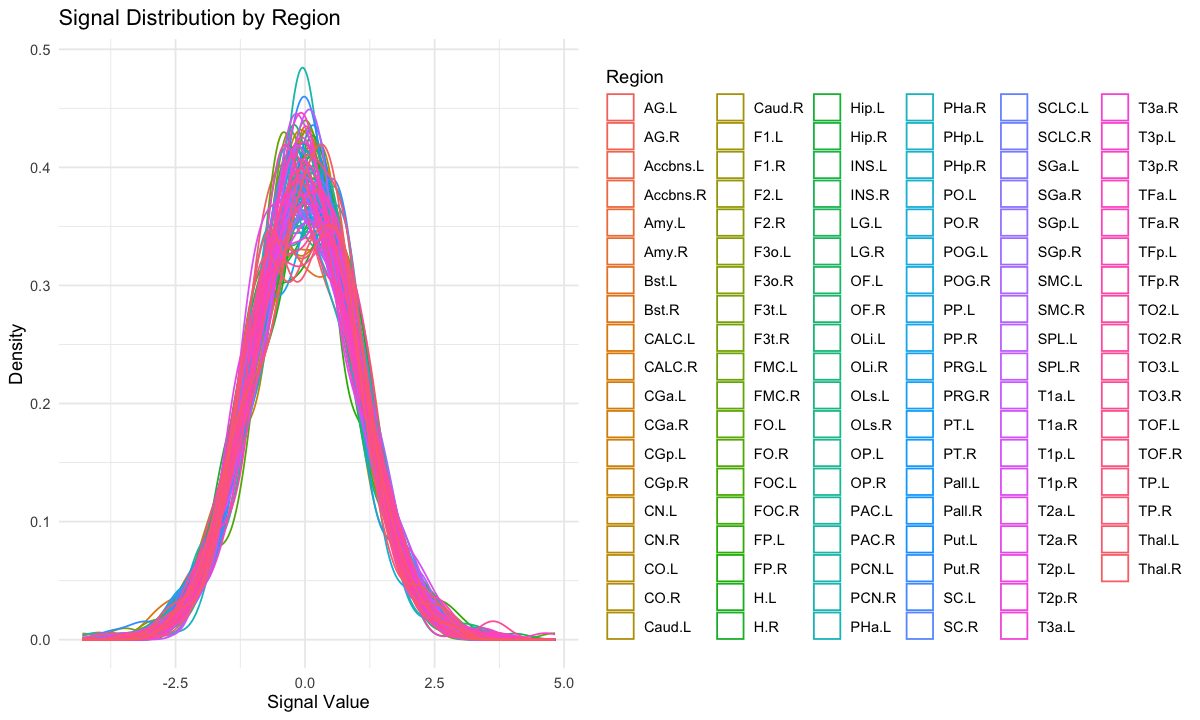

In [9]:
# Convert to long format for ggplot
errts_long <- pivot_longer(errts.TP_E3834_rest, cols = everything(),
  names_to = "Region", values_to = "Signal")

# Plot density for each region (overlayed)
ggplot(errts_long, aes(x = Signal, color = Region)) +
  geom_density() +
  labs(title = "Signal Distribution by Region", x = "Signal Value", y = "Density") +
  theme_minimal()

### Smoothing

Below is kernel smoothing

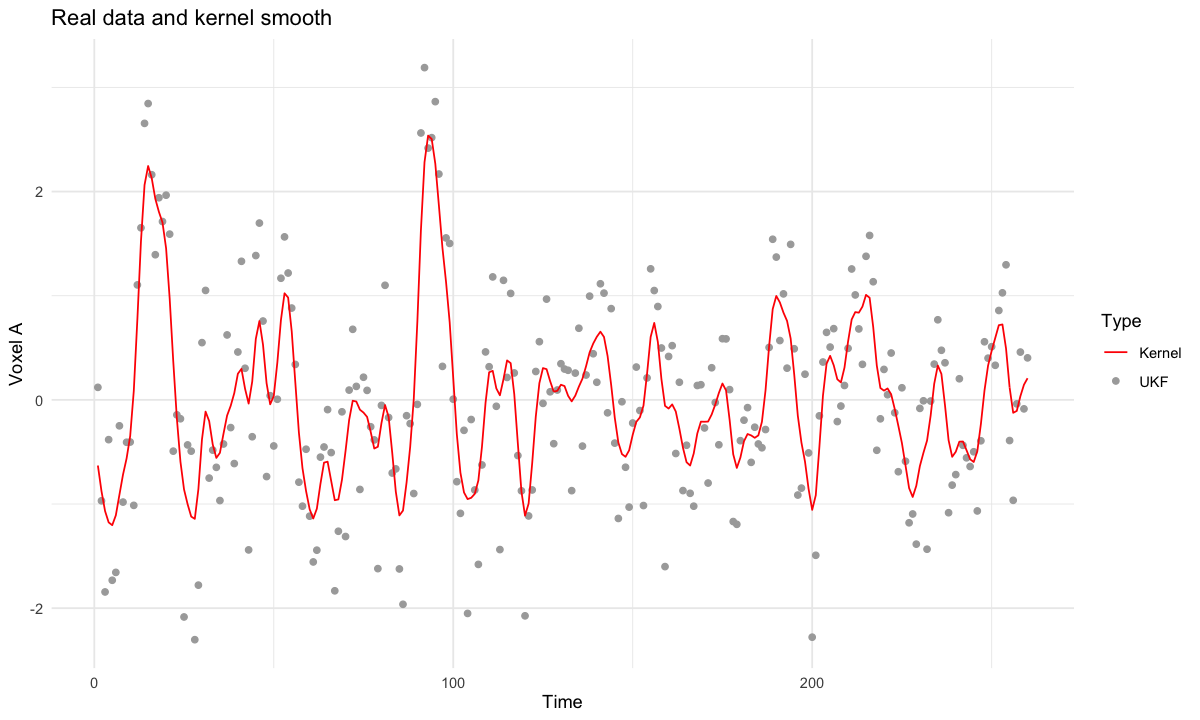

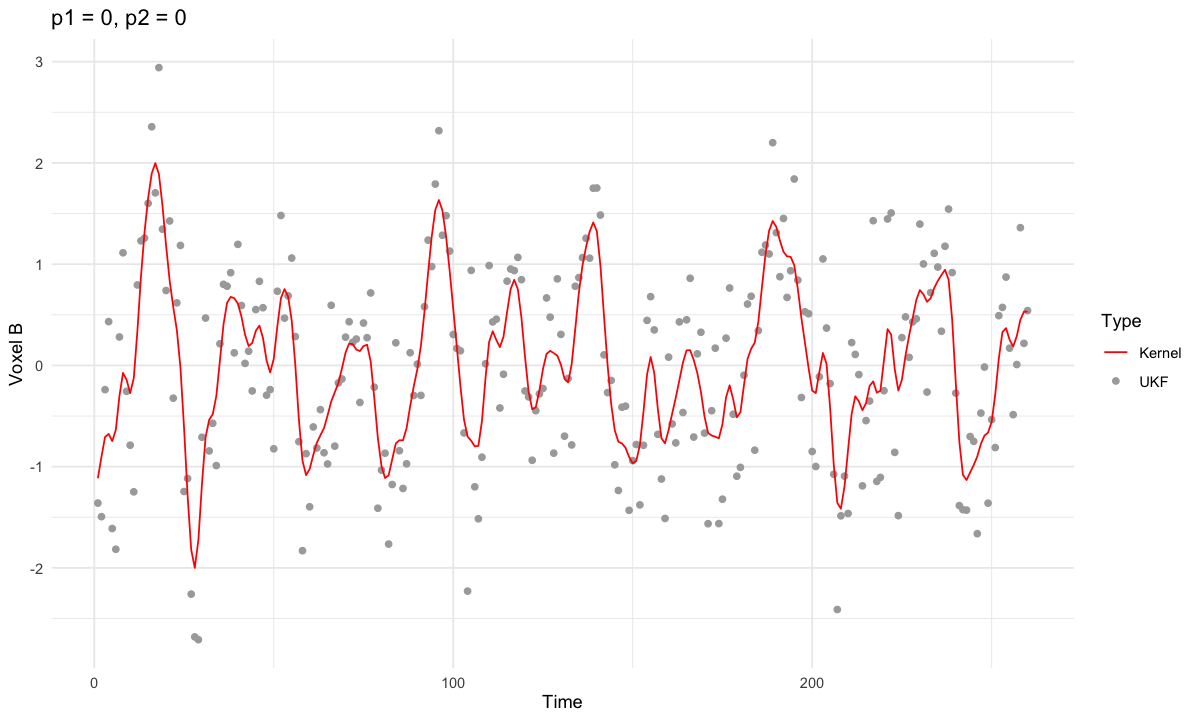

In [10]:
# Create time steps based on number of rows
time_steps <- seq(1, nrow(errts.TP_E3834_rest))

# Create a region pair with FP.L and FP.R, aligned with time steps
errts.TP_E3834_rest_FP_LR <- cbind(time_steps, errts.TP_E3834_rest["FP.L"], errts.TP_E3834_rest["FP.R"])
smoothed_errts.TP_E3834_rest_FP_LR <- plot_voxels_and_smooth_ggplot(errts.TP_E3834_rest_FP_LR)

Kernel smoothing might be too much,

Smoothing with bandwith

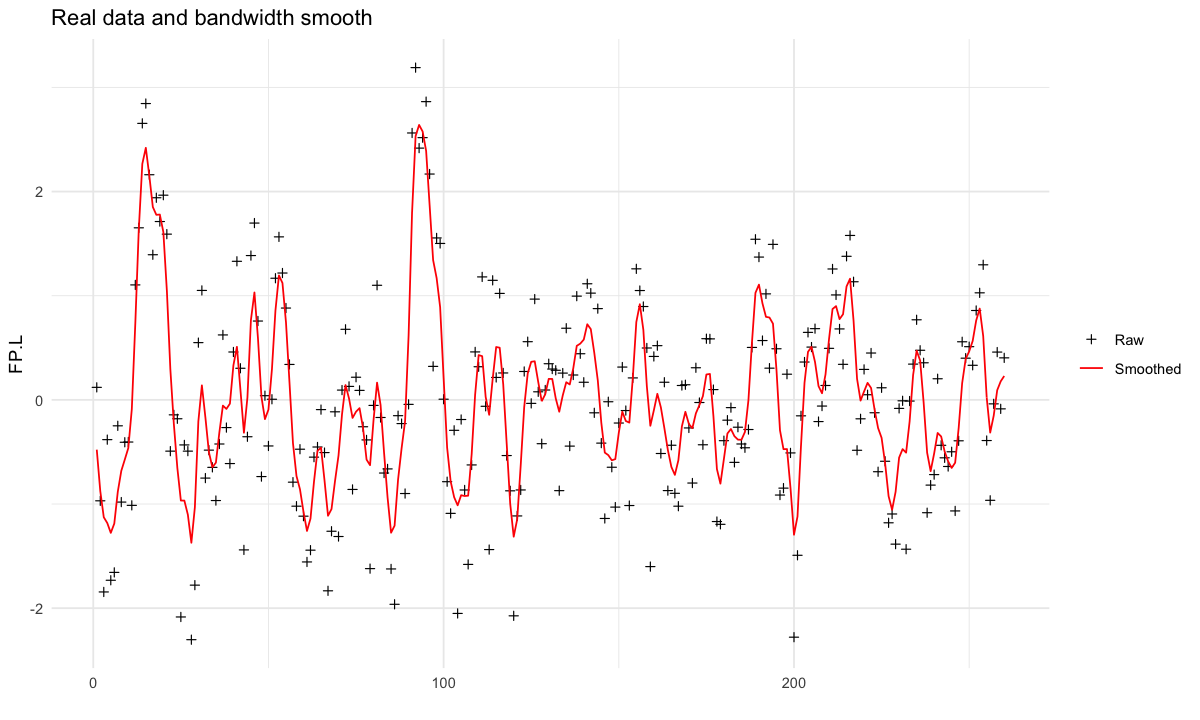

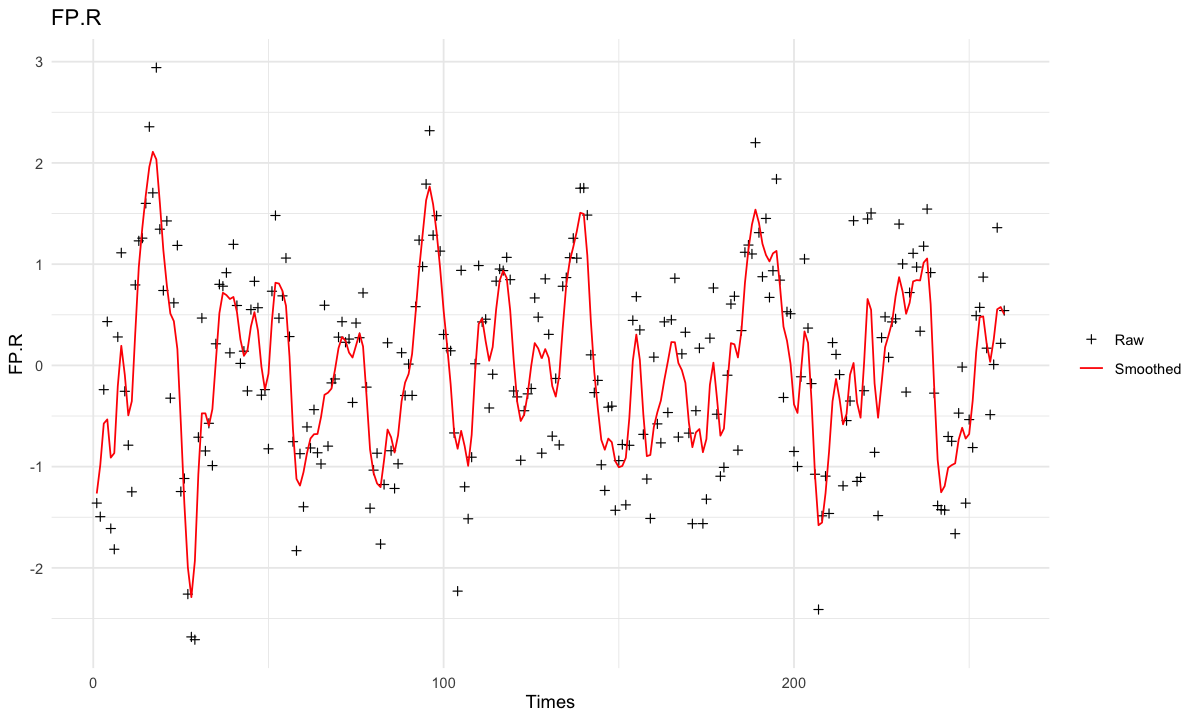

In [11]:
smoothed_errts.TP_E3834_rest_FP_LR <- smooth_subject_data(errts.TP_E3834_rest_FP_LR, bandwidth = 3)

plot_bandwidth_smoothed_ggplot(errts.TP_E3834_rest_FP_LR, smoothed_errts.TP_E3834_rest_FP_LR, top_title = "Real data and bandwidth smooth")

## UKF - single pass

In [12]:
ukf_data <- as.matrix(smoothed_errts.TP_E3834_rest_FP_LR)

In [13]:
param_guess <- c(1, 1, 1)
t_vec <- ukf_data[, 1] # time is first column
dT <- t_vec[2] - t_vec[1]   # assume uniform time steps dT=1
# smaller steps size for propagating model between dT steps
dt <- 0.1 * dT
# num observed ind vars, first col is time, so -1
N_y <- ncol(ukf_data) - 1  # N_y=2
# number of unknown model parameters to be estimated
N_p <- 3
# size of augmented state vector
N_x <- N_p + 2 * N_y

Run UKF with new coupled oscillator model and smoothed data as input one pass through the time series

0.137296
41.243163
31.255870


[1] 0.07209386

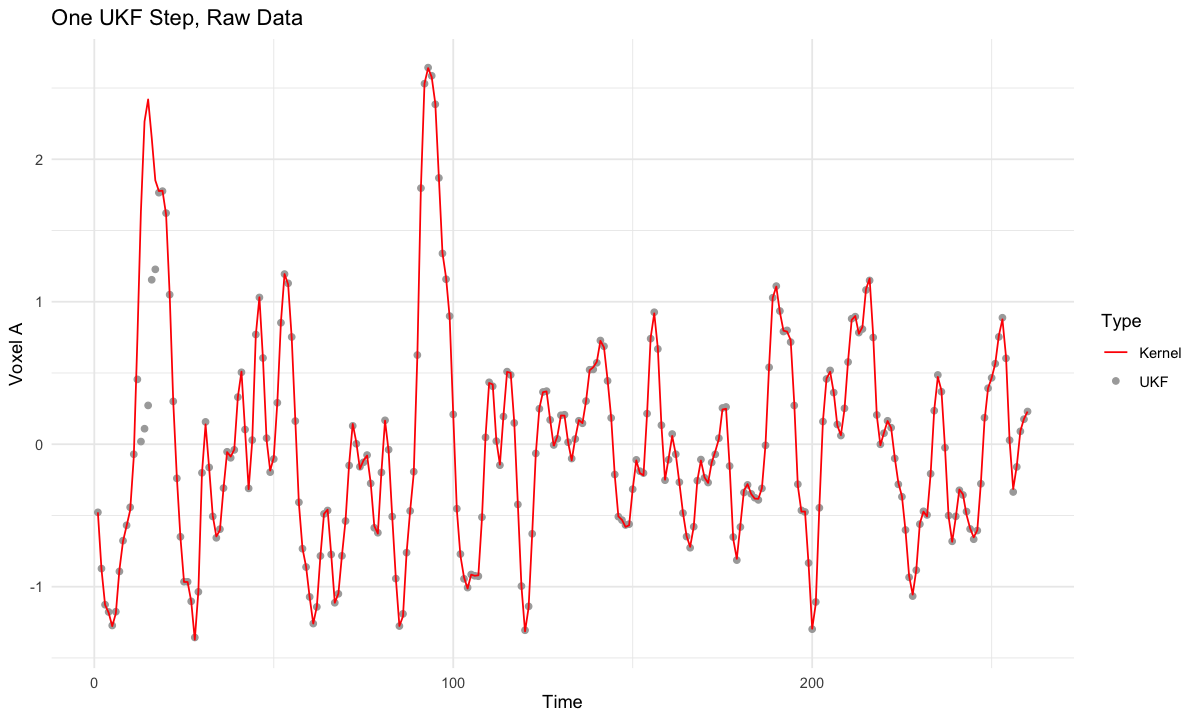

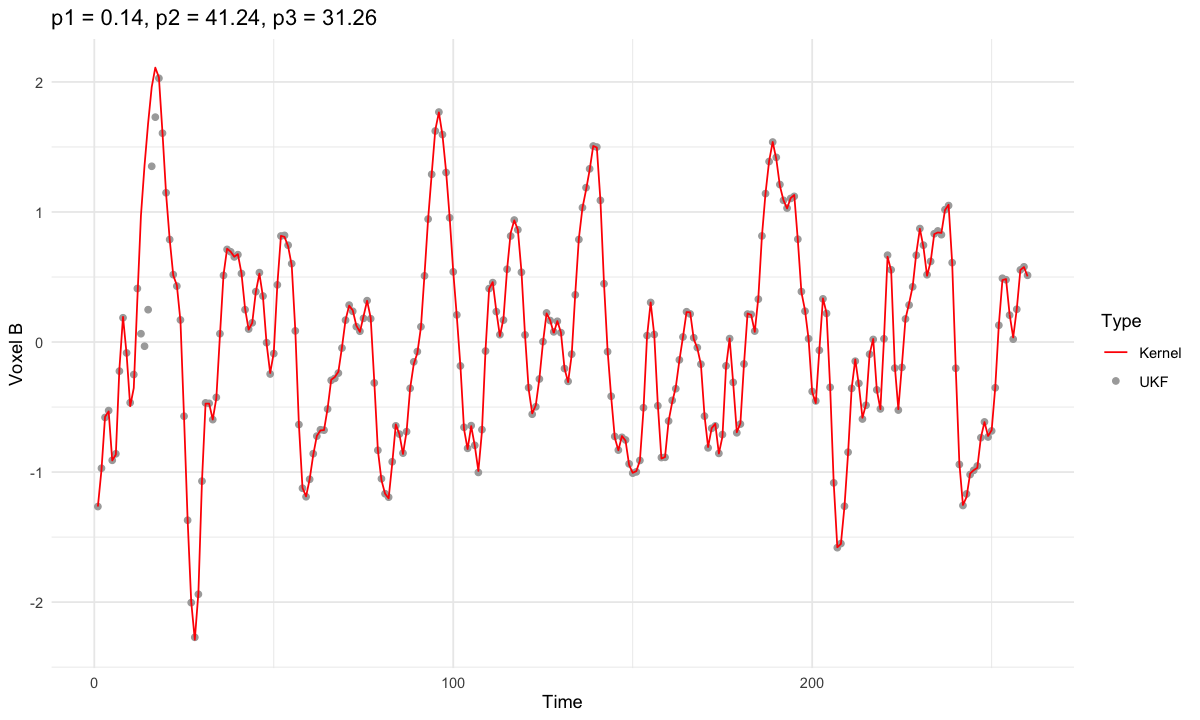

In [14]:
ukf_out <- UKF_blend(t_dummy, ukf_data, coupled_osc_model_abk,
                    N_p, N_y, param_guess, dt, dT,
                    R_scale = 0.01, Q_scale = 0.1,
                    forcePositive = TRUE, seeded = TRUE,
                    method = "streamlined")
ukf_out$param_est
ukf_out$chisq
plot_ukf_and_smoothed_ggplot(ukf_out, smoothed_errts.TP_E3834_rest_FP_LR, 
        top_title = 'One UKF Step, Raw Data')

## UKF - iterative optimization

Streamlined method iterative optimization, abk model

Iterative Parameter Optimization Results:
Estimated Parameters:
 a  :  14.1886 
 b  :  0.5899535 
 k  :  38.02046 

Chi-Square Value:  0.0001294241
Number of Steps:  1000
Parameter Norm:  5.170627


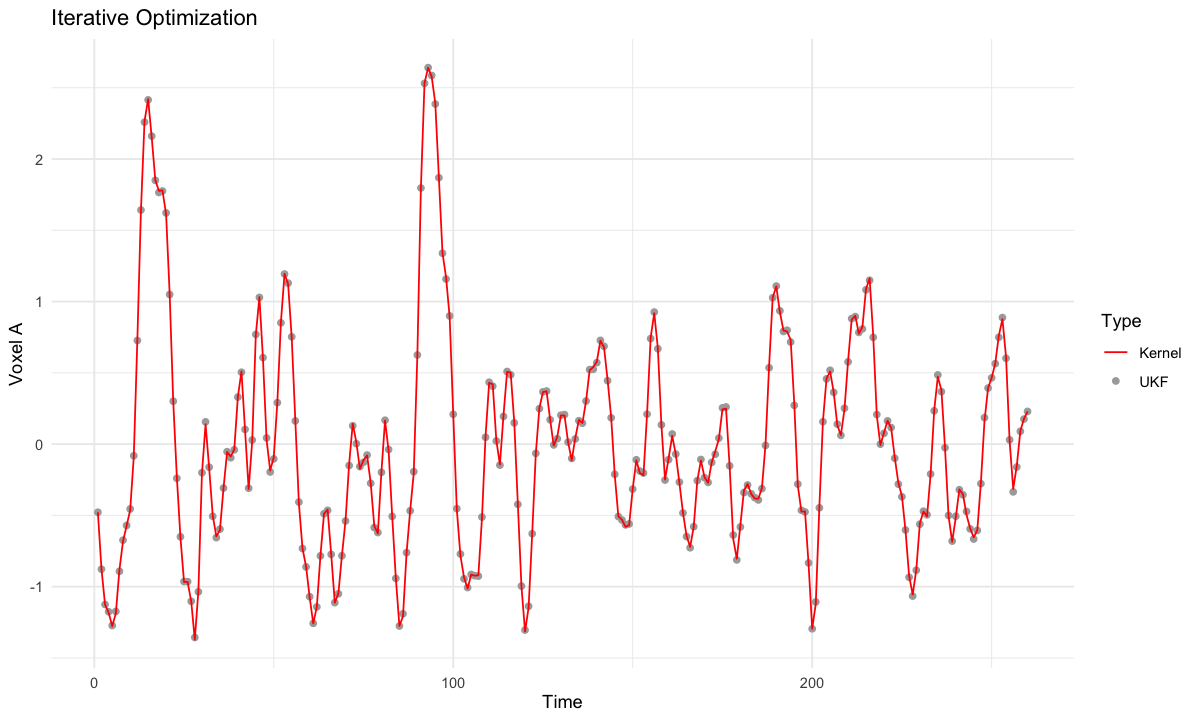

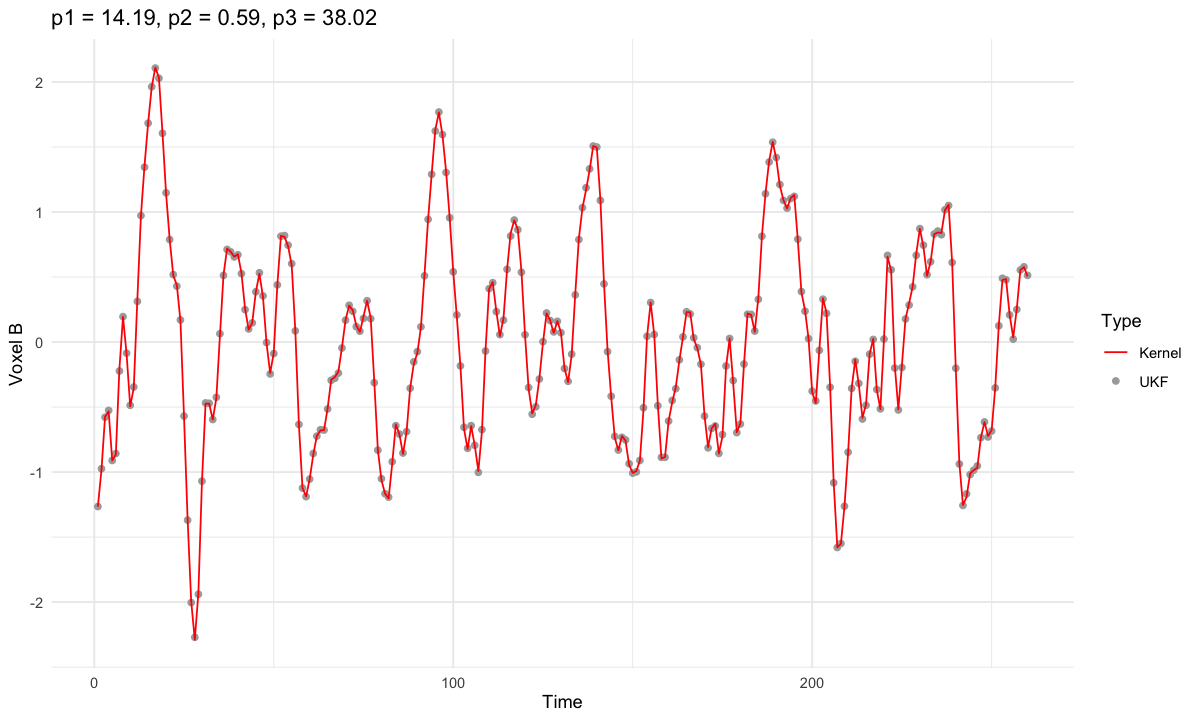

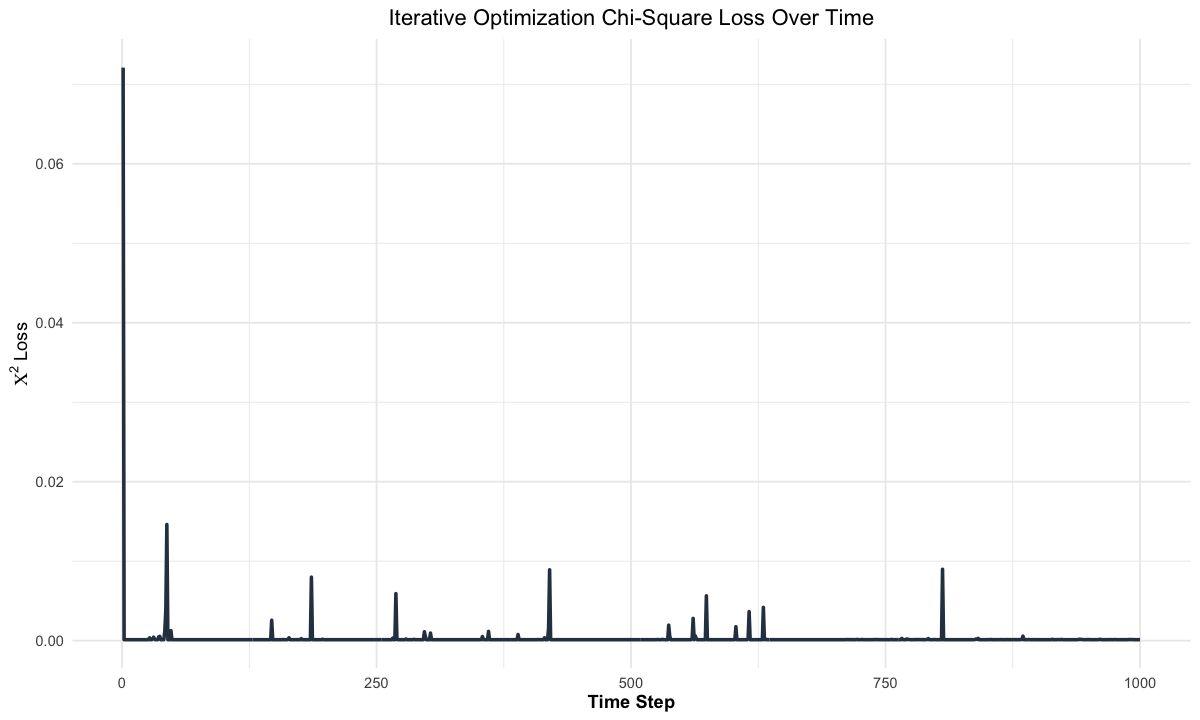

In [15]:
t_vec <- ukf_data[, 1]
dT <- t_vec[2] - t_vec[1]
dt <- 0.1 * dT
N_y <- ncol(ukf_data) - 1
N_p <- 3
param_guess <- c(1, 1, 1) # a, b, k

iter_opt <- iterative_param_optim(param_guess, t_dummy, smoothed_errts.TP_E3834_rest_FP_LR, coupled_osc_model_abk,
                                    N_p, N_y, dt, dT,
                                    param_tol = .001, MAXSTEPS = 1000, forcePositive = TRUE,
                                    R_scale = 0.01, Q_scale = 0.1, trace = FALSE, seeded = TRUE)

print_iterative_param_optim(iter_opt)

# Plot the results
plot_ukf_and_smoothed_ggplot(iter_opt, smoothed_errts.TP_E3834_rest_FP_LR, top_title = 'Iterative Optimization')
plot_ukf_chi_square_loss(iter_opt, title = "Iterative Optimization Chi-Square Loss Over Time")

Standard method iterative optimization

Iterative Parameter Optimization Results:
Estimated Parameters:
 a  :  36.05309 
 b  :  0.001030497 
 k  :  27.09682 

Chi-Square Value:  0.0003132803
Number of Steps:  7
Parameter Norm:  0.0009184044


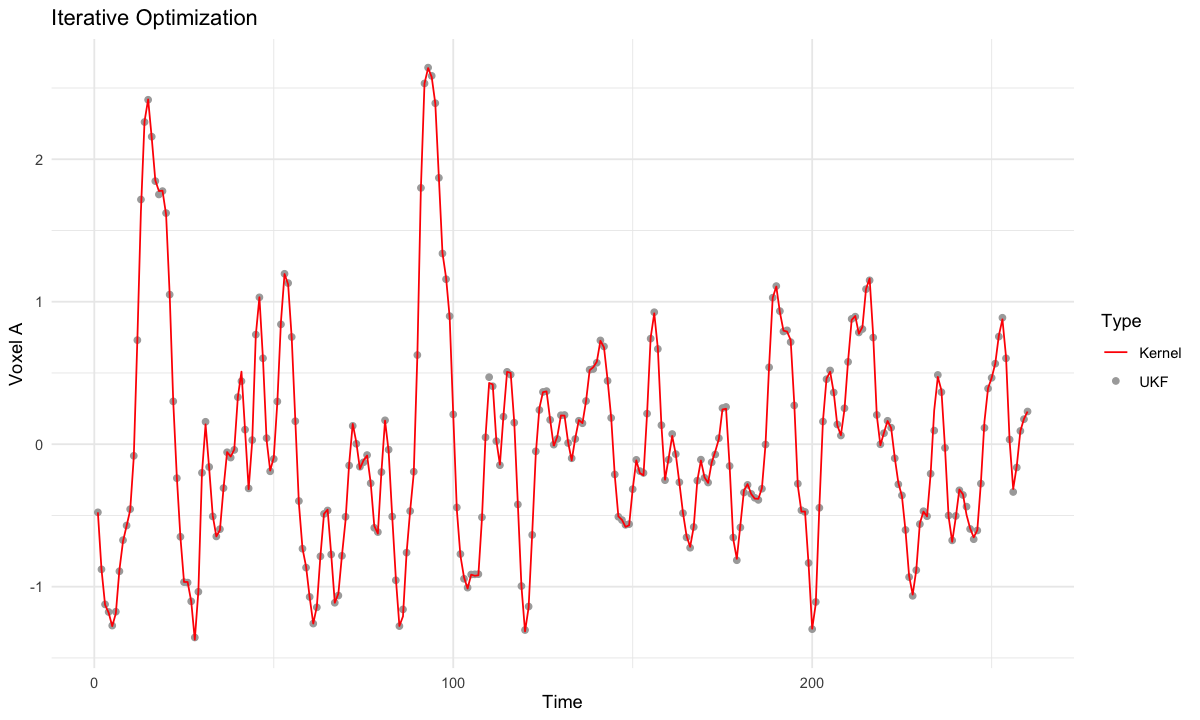

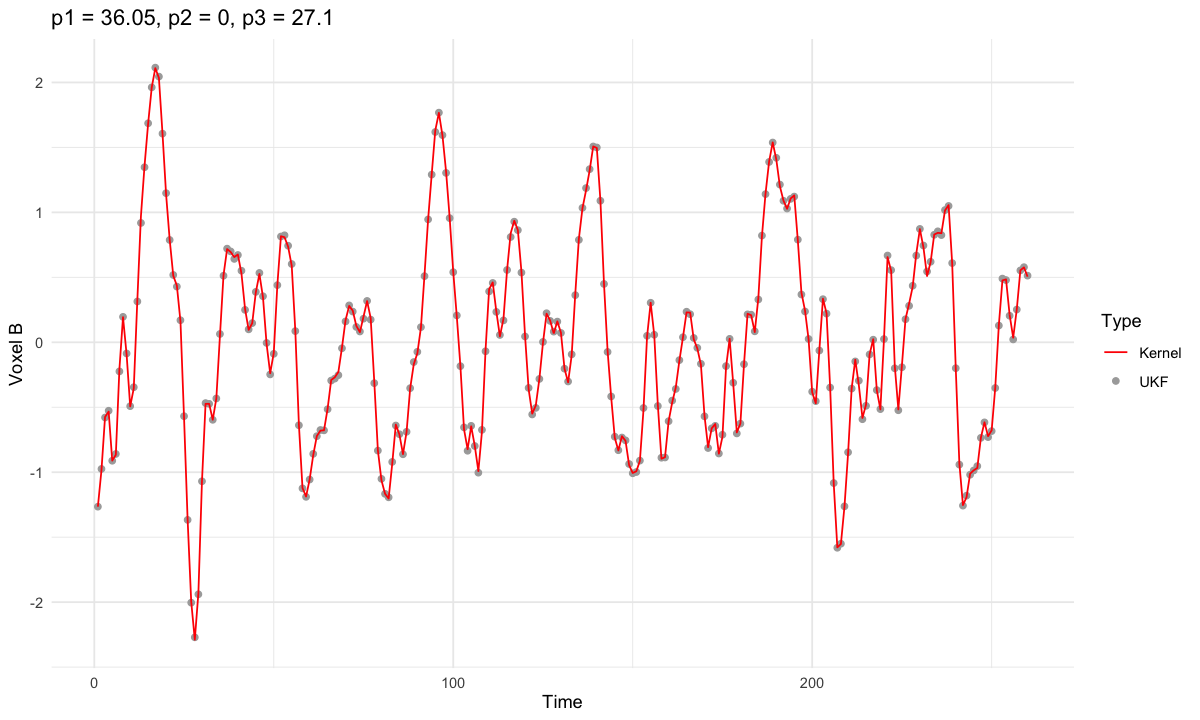

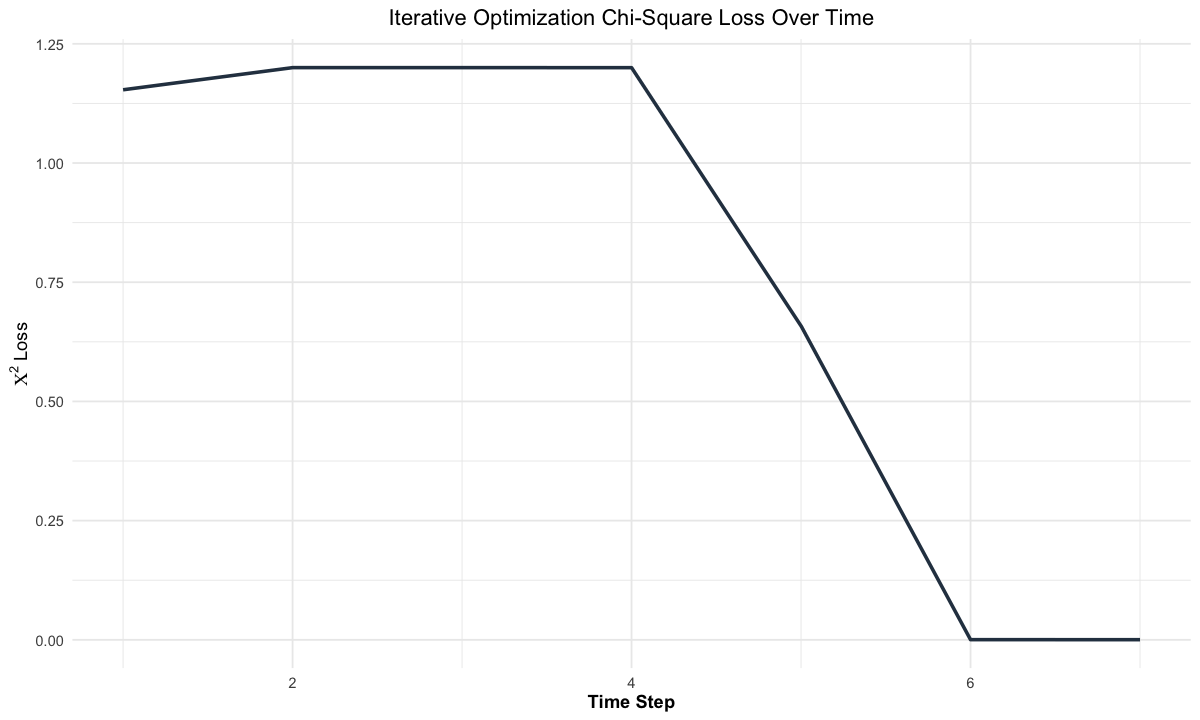

In [16]:
iter_opt <- iterative_param_optim(param_guess, t_dummy, smoothed_errts.TP_E3834_rest_FP_LR, coupled_osc_model_abk,
                                    N_p, N_y, dt, dT,
                                    param_tol = .001, MAXSTEPS = 1000, forcePositive = TRUE,
                                    R_scale = 0.01, Q_scale = 0.1, trace = FALSE, seeded = TRUE,
                                    method = "standard")

print_iterative_param_optim(iter_opt)

# Plot the results
plot_ukf_and_smoothed_ggplot(iter_opt, smoothed_errts.TP_E3834_rest_FP_LR, top_title = 'Iterative Optimization')
plot_ukf_chi_square_loss(iter_opt, title = "Iterative Optimization Chi-Square Loss Over Time")

Standard method iterative optimization

Iterative Parameter Optimization Results:
Estimated Parameters:
 a  :  32.4054 
 b  :  29.06915 
 k  :  12.22276 

Chi-Square Value:  0.01240219
Number of Steps:  53
Parameter Norm:  0.009247504


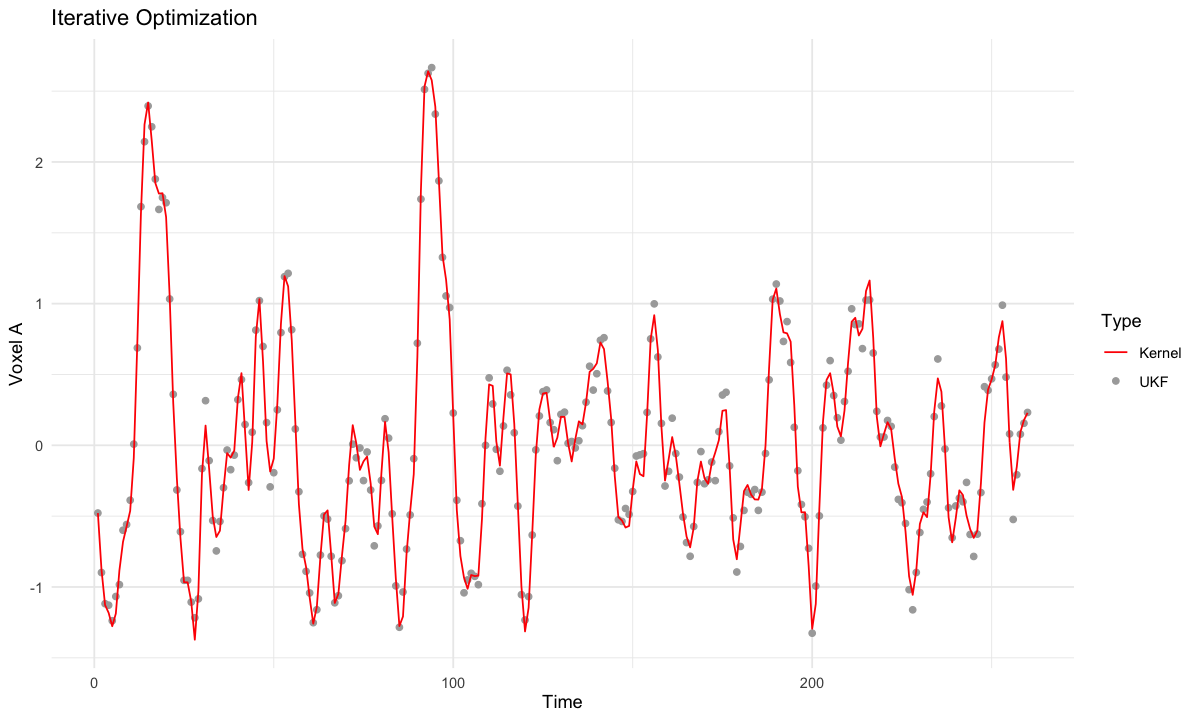

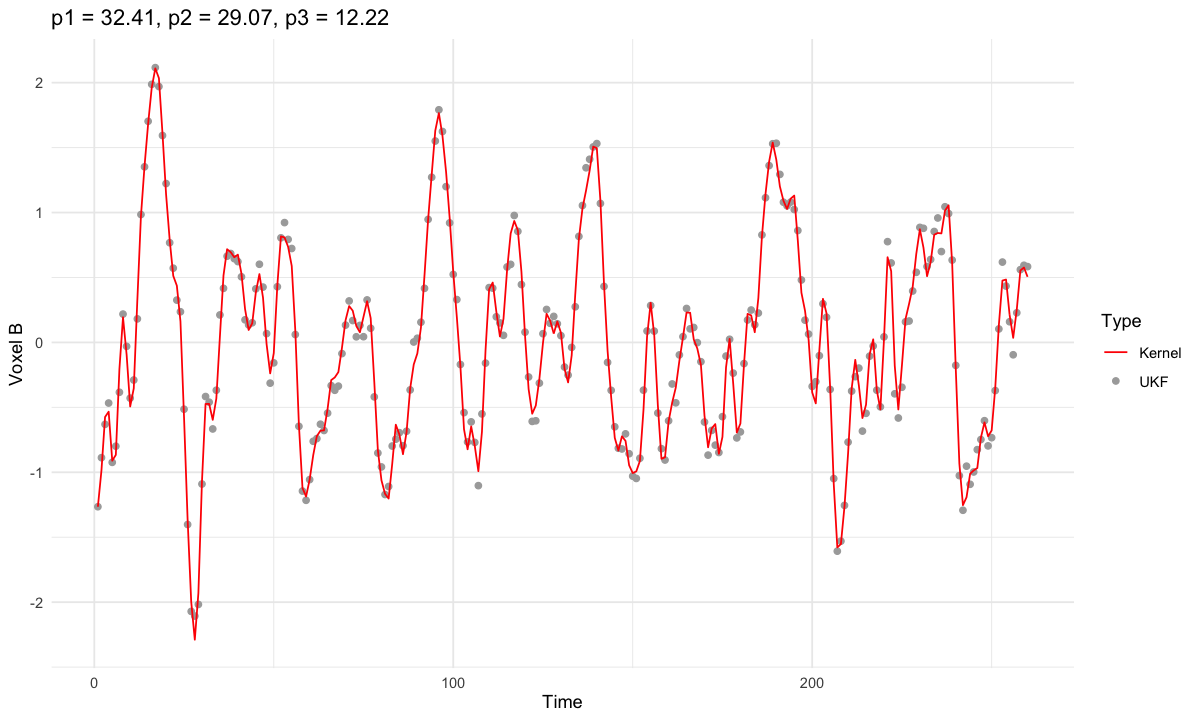

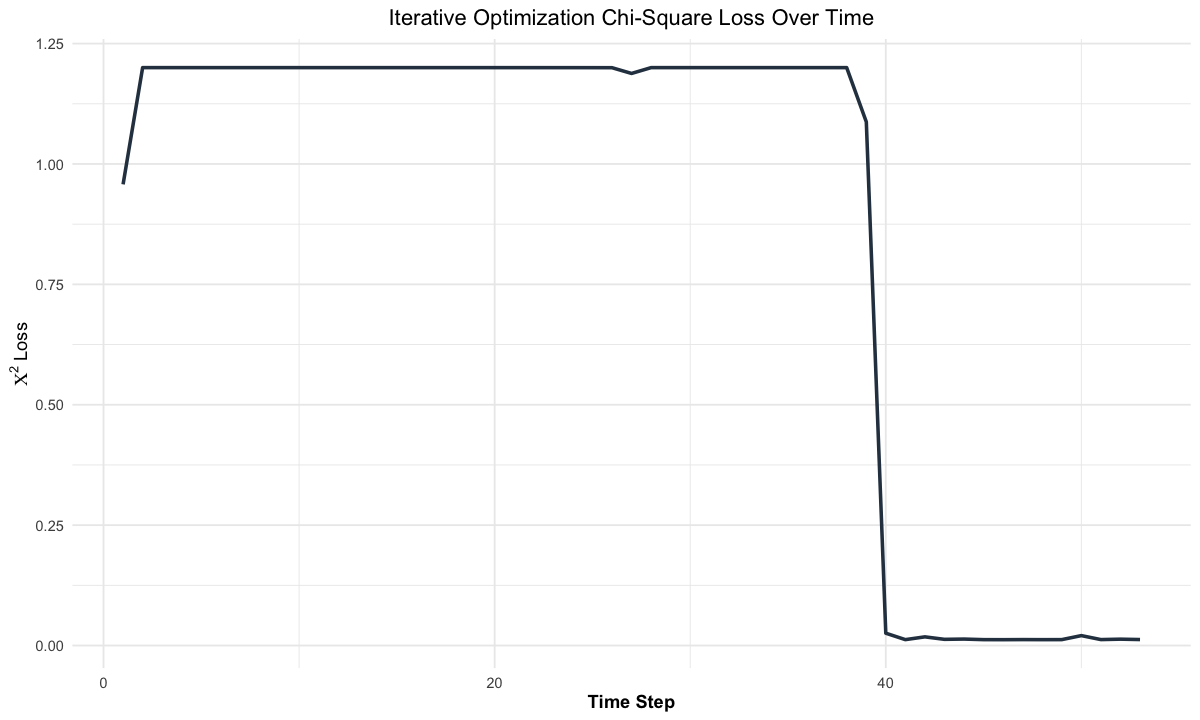

In [21]:
iter_opt <- iterative_param_optim(param_guess, t_dummy, smoothed_errts.TP_E3834_rest_FP_LR, coupled_osc_model_abk,
                                    N_p, N_y, dt, dT,
                                    param_tol = .01, MAXSTEPS = 1000, forcePositive = TRUE,
                                    R_scale = 0.1, Q_scale = 1, trace = FALSE, seeded = TRUE,
                                    method = "standard")

print_iterative_param_optim(iter_opt)

# Plot the results
plot_ukf_and_smoothed_ggplot(iter_opt, smoothed_errts.TP_E3834_rest_FP_LR, top_title = 'Iterative Optimization')
plot_ukf_chi_square_loss(iter_opt, title = "Iterative Optimization Chi-Square Loss Over Time")

Iterative Parameter Optimization Results:
Estimated Parameters:
 a  :  3.486019 
 b  :  54.37926 
 k  :  17.40354 

Chi-Square Value:  0.01218887
Number of Steps:  63
Parameter Norm:  0.003742984


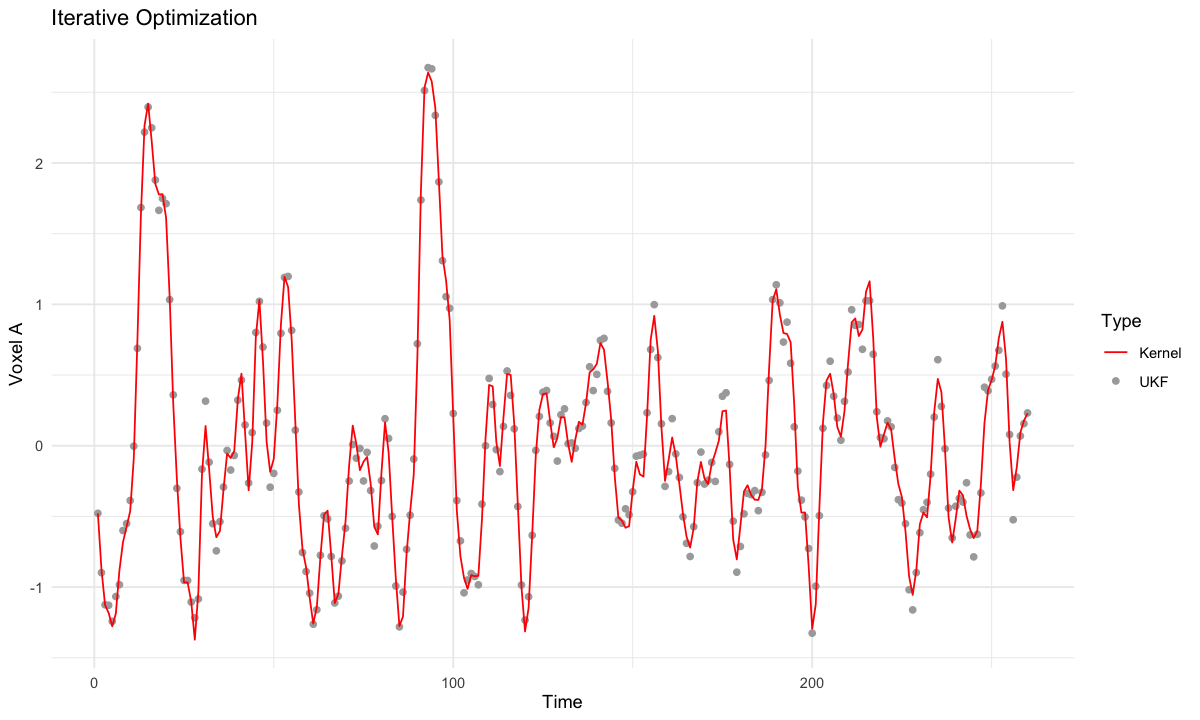

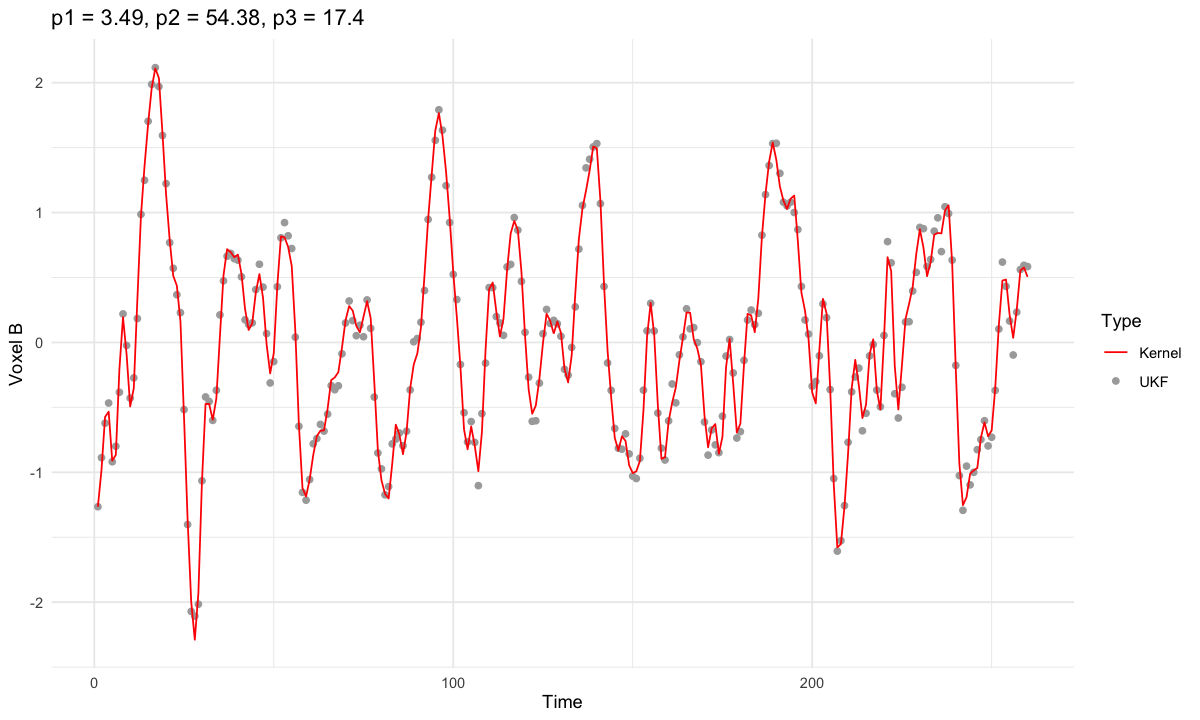

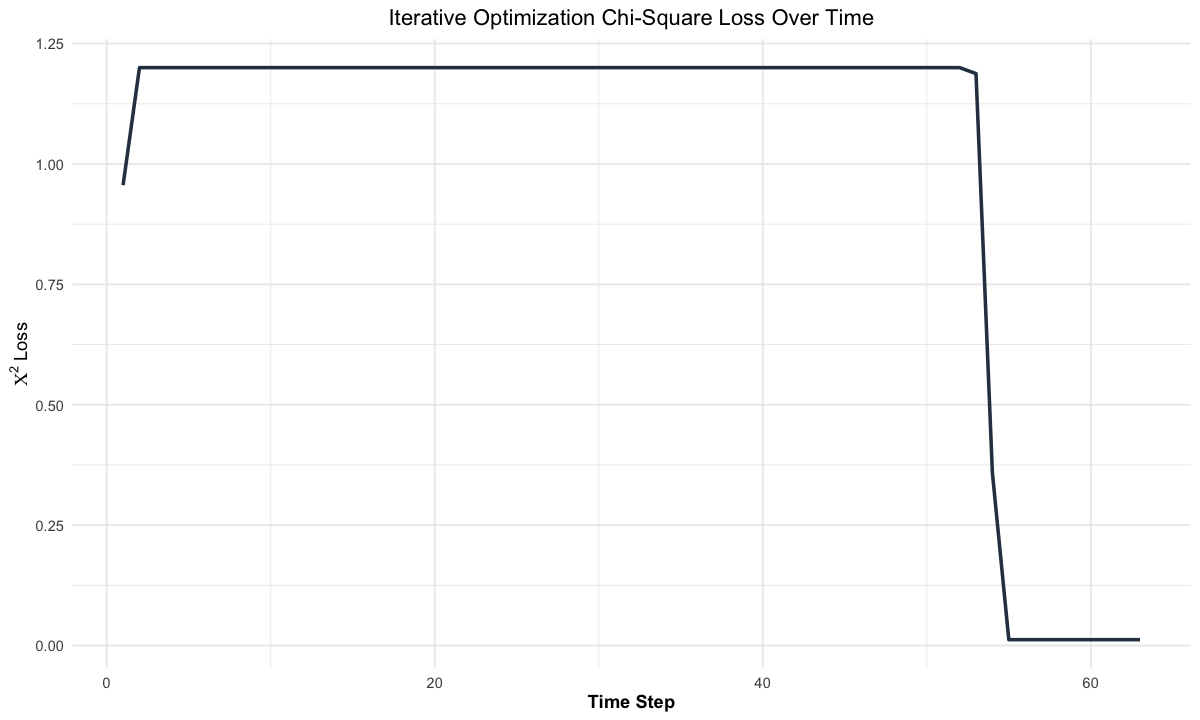

In [22]:
iter_opt <- iterative_param_optim(param_guess, t_dummy, smoothed_errts.TP_E3834_rest_FP_LR, coupled_osc_model_abk,
                                    N_p, N_y, dt, dT,
                                    param_tol = .01, MAXSTEPS = 1000, forcePositive = TRUE,
                                    R_scale = 0.1, Q_scale = 3, trace = FALSE, seeded = TRUE,
                                    method = "standard")

print_iterative_param_optim(iter_opt)

# Plot the results
plot_ukf_and_smoothed_ggplot(iter_opt, smoothed_errts.TP_E3834_rest_FP_LR, top_title = 'Iterative Optimization')
plot_ukf_chi_square_loss(iter_opt, title = "Iterative Optimization Chi-Square Loss Over Time")